# Calculate the area of ORCA2 Grid

In [1]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

# Great circle distance/bearing

http://www.movable-type.co.uk/scripts/latlong.html

In [2]:
def GreatCircleBearing(lon1, lat1, lon2, lat2):
    dlon = lon1 - lon2
    d2r = np.pi/180.0
    s = np.cos(d2r*lat2)*np.sin(d2r*dlon)
    c = np.cos(d2r*lat1)*np.sin(d2r*lat2) - np.sin(lat1*d2r)*np.cos(d2r*lat2)*np.cos(d2r*dlon)
    return np.arctan2(s, c)

def cal_area(lons, lats):
    R = 6371.393
    N = len(lons)
    angles = np.empty(N)
    for i in range(N):
        phiB1, phiA, phiB2 = np.roll(lats, i)[:3]
        LB1, LA, LB2 = np.roll(lons, i)[:3]
        # calculate angle with north (eastward)
        beta1 = GreatCircleBearing(LA, phiA, LB1, phiB1)
        beta2 = GreatCircleBearing(LA, phiA, LB2, phiB2)
        # calculate angle between the polygons and add to angle array
        angles[i] = np.arccos(np.cos(-beta1)*np.cos(-beta2) + np.sin(-beta1)*np.sin(-beta2))
    return (sum(angles) - (N-2)*np.pi)*R**2

<img src="_figures/GCArea.png" width=500 align="left"/>

In [3]:
lons = np.array([10, 10, 20, 20])
lats = np.array([80, 70, 70, 80])
cal_area(lons, lats)

318203.64195450902

In [4]:
# Calculate the surface area of earth
lons = np.array([0, 0, 180, 180])
lats = np.array([90, -90, -90, 90])
cal_area(lons, lats)*2

510127401.28353834

# ORCA2 C-Grid

<img src="_figures/C-Grid.PNG" width=180 align="left"/>

In [5]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
glamu=coordinate_obj.variables['glamu'][:]
glamv=coordinate_obj.variables['glamv'][:]
gphiu=coordinate_obj.variables['gphiu'][:]
gphiv=coordinate_obj.variables['gphiv'][:]

In [6]:
L = 182-1; W = 149-1
area = np.empty(nav_lon.shape)
for i in range(L):
    for j in range(W):
        lons = np.array([glamv[j, i], glamv[j, i]  , glamv[j, i+1], glamv[j, i+1]])
        lats = np.array([gphiu[j, i], gphiu[j+1, i], gphiu[j+1, i], gphiu[j, i]  ])
        area[j, i] = cal_area(lons, lats)
area[:, L] = area[:, L-1]
area[W, :] = area[W-1, :]

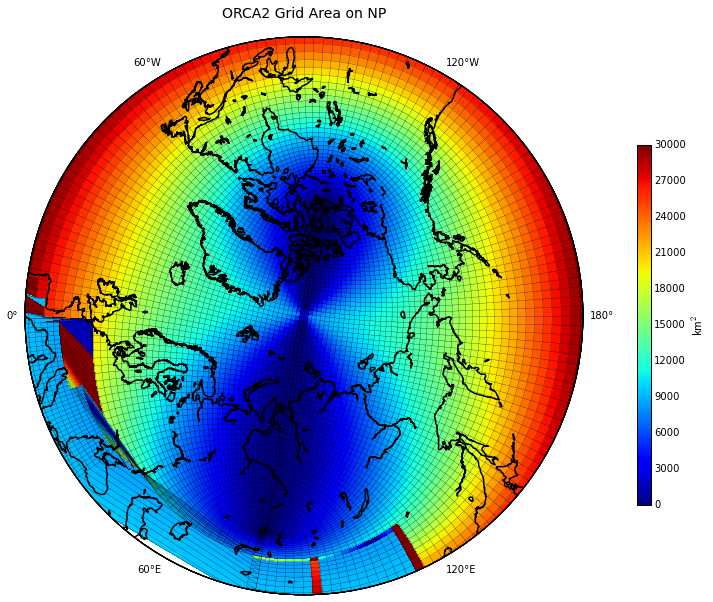

In [7]:
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=40, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
x, y = proj(nav_lon, nav_lat)
CS = proj.pcolor(x, y, area, vmin=0, vmax=30000)
proj.plot(x, y, 'k-', lw=0.25); proj.plot(x.T, y.T, 'k-', lw=0.25);
cbaxes = fig.add_axes([0.975, 0.25, 0.02, 0.5]) 
CBar = plt.colorbar(CS, ax=ax, cax=cbaxes) 
CBar.set_label('$\mathsf{km^2}$', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
ax.set_title('ORCA2 Grid Area on NP', fontsize=14, y=1.025)